In [2]:
import os
import hashlib

DATASET_ROOT = "/home/wizz/ML Project/Dataset"   # change if needed

splits = ["train", "validate", "test"]  # Changed "val" to "validate"
classes = ["0", "1"]   # assuming binary: real = 0, fake = 1


def file_hash(filepath):
    """Generate a SHA1 hash of the file to check duplicates even with different names."""
    h = hashlib.sha1()
    with open(filepath, "rb") as f:
        h.update(f.read())
    return h.hexdigest()


def scan_folder(path):
    """Return set of filenames and hashes for all files in a folder."""
    names = set()
    hashes = set()
    paths = []

    for root, _, files in os.walk(path):
        for f in files:
            full_path = os.path.join(root, f)
            names.add(f)
            hashes.add(file_hash(full_path))
            paths.append(full_path)

    return names, hashes, paths


print("=== SCANNING DATASET FOR CROSS-CONTAMINATION ===")

for split in splits:
    print(f"\nChecking split: {split.upper()}")
    class_paths = {c: os.path.join(DATASET_ROOT, split, c) for c in classes}

    # scan classes
    data = {}
    for c in classes:
        if not os.path.exists(class_paths[c]):
            print(f"❌ Missing folder: {class_paths[c]}")
            continue
        data[c] = scan_folder(class_paths[c])

    # Only proceed if both classes were scanned
    if "0" not in data or "1" not in data:
        print(f"⚠️ Skipping {split} - missing class folders")
        continue

    # comparisons
    names_0, hashes_0, _ = data["0"]
    names_1, hashes_1, _ = data["1"]

    # Check if any filename exists in both classes
    name_overlap = names_0.intersection(names_1)
    hash_overlap = hashes_0.intersection(hashes_1)

    if name_overlap:
        print("⚠️ SAME FILENAMES FOUND IN BOTH CLASSES:")
        for x in name_overlap:
            print("   -", x)

    if hash_overlap:
        print("❌ SAME IMAGE FOUND IN BOTH CLASSES (DUPLICATE CONTENT):")
        for h in hash_overlap:
            print("   - SHA1:", h)

    if not name_overlap and not hash_overlap:
        print("✅ No file contamination between class 0 and class 1.")


print("\n=== CHECK COMPLETE ===")

=== SCANNING DATASET FOR CROSS-CONTAMINATION ===

Checking split: TRAIN
✅ No file contamination between class 0 and class 1.

Checking split: VALIDATE
✅ No file contamination between class 0 and class 1.

Checking split: VALIDATE
✅ No file contamination between class 0 and class 1.

Checking split: TEST
✅ No file contamination between class 0 and class 1.

Checking split: TEST
✅ No file contamination between class 0 and class 1.

=== CHECK COMPLETE ===
✅ No file contamination between class 0 and class 1.

=== CHECK COMPLETE ===


# Model Evaluation & Analysis
Complete analysis of the deepfake detector model on test dataset including confusion matrix, classification report, and performance metrics.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import os

# Load the trained model
print("Loading model...")
model = tf.keras.models.load_model('deepfake_detector_v4_improved.h5')
print("✅ Model loaded!\n")

# Load test dataset
IMG_SIZE = (256, 256)
BATCH_SIZE = 16
data_dir = "/home/wizz/ML Project/Dataset"
test_dir = os.path.join(data_dir, 'test')

print("Loading test dataset...")
test_ds = image_dataset_from_directory(
    test_dir,
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=False
)

class_names = test_ds.class_names
print(f"Classes: {class_names}")
print(f"  - Class 0: Real images")
print(f"  - Class 1: Fake images")
print(f"Test batches: {tf.data.experimental.cardinality(test_ds).numpy()}\n")

Loading model...


I0000 00:00:1764790101.847946    8320 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


✅ Model loaded!

Loading test dataset...
Found 2000 files belonging to 2 classes.
Classes: ['0', '1']
  - Class 0: Real images
  - Class 1: Fake images
Test batches: 125

Classes: ['0', '1']
  - Class 0: Real images
  - Class 1: Fake images
Test batches: 125



In [13]:
# Get predictions and true labels
print("Generating predictions on test set...")
y_true_list = []
y_pred_probs_list = []

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_pred_probs_list.extend(predictions.flatten())
    y_true_list.extend(labels.numpy())

# Convert to numpy arrays with explicit shape
y_true = np.array(y_true_list, dtype=np.float32).flatten()
y_pred_probs = np.array(y_pred_probs_list, dtype=np.float32).flatten()
y_pred = (y_pred_probs >= 0.5).astype(np.int32)

print(f"✅ Predictions complete!")
print(f"Total samples: {len(y_true)}")
print(f"y_true shape: {y_true.shape}, dtype: {y_true.dtype}")
print(f"y_pred_probs shape: {y_pred_probs.shape}, dtype: {y_pred_probs.dtype}")
print(f"y_pred shape: {y_pred.shape}, dtype: {y_pred.dtype}")
print(f"Real samples (class 0): {np.sum(y_true == 0)}")
print(f"Fake samples (class 1): {np.sum(y_true == 1)}\n")

Generating predictions on test set...
✅ Predictions complete!
Total samples: 2000
y_true shape: (2000,), dtype: float32
y_pred_probs shape: (2000,), dtype: float32
y_pred shape: (2000,), dtype: int32
Real samples (class 0): 1000
Fake samples (class 1): 1000

✅ Predictions complete!
Total samples: 2000
y_true shape: (2000,), dtype: float32
y_pred_probs shape: (2000,), dtype: float32
y_pred shape: (2000,), dtype: int32
Real samples (class 0): 1000
Fake samples (class 1): 1000



2025-12-04 00:39:29.167575: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


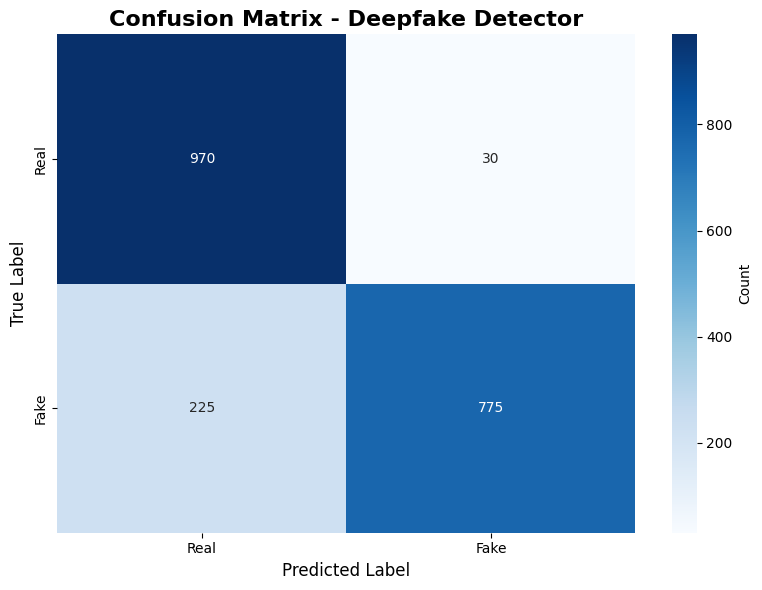

Confusion Matrix:
  True Negatives (Real → Real):  970
  False Positives (Real → Fake): 30
  False Negatives (Fake → Real): 225
  True Positives (Fake → Fake):  775


In [14]:
# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], 
            yticklabels=['Real', 'Fake'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Deepfake Detector', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Print confusion matrix values
print("Confusion Matrix:")
print(f"  True Negatives (Real → Real):  {cm[0, 0]}")
print(f"  False Positives (Real → Fake): {cm[0, 1]}")
print(f"  False Negatives (Fake → Real): {cm[1, 0]}")
print(f"  True Positives (Fake → Fake):  {cm[1, 1]}")

In [8]:
# 2. Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
report = classification_report(y_true, y_pred, 
                              target_names=['Real (0)', 'Fake (1)'], 
                              digits=4)
print(report)

# Calculate additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("="*60)
print("SUMMARY METRICS")
print("="*60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} (How many predicted fakes are actually fake)")
print(f"Recall:    {recall:.4f} (How many actual fakes were detected)")
print(f"F1-Score:  {f1:.4f} (Harmonic mean of precision and recall)")
print("="*60)


CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Real (0)     0.8117    0.9700    0.8838      1000
    Fake (1)     0.9627    0.7750    0.8587      1000

    accuracy                         0.8725      2000
   macro avg     0.8872    0.8725    0.8713      2000
weighted avg     0.8872    0.8725    0.8713      2000

SUMMARY METRICS
Accuracy:  0.8725 (87.25%)
Precision: 0.9627 (How many predicted fakes are actually fake)
Recall:    0.7750 (How many actual fakes were detected)
F1-Score:  0.8587 (Harmonic mean of precision and recall)


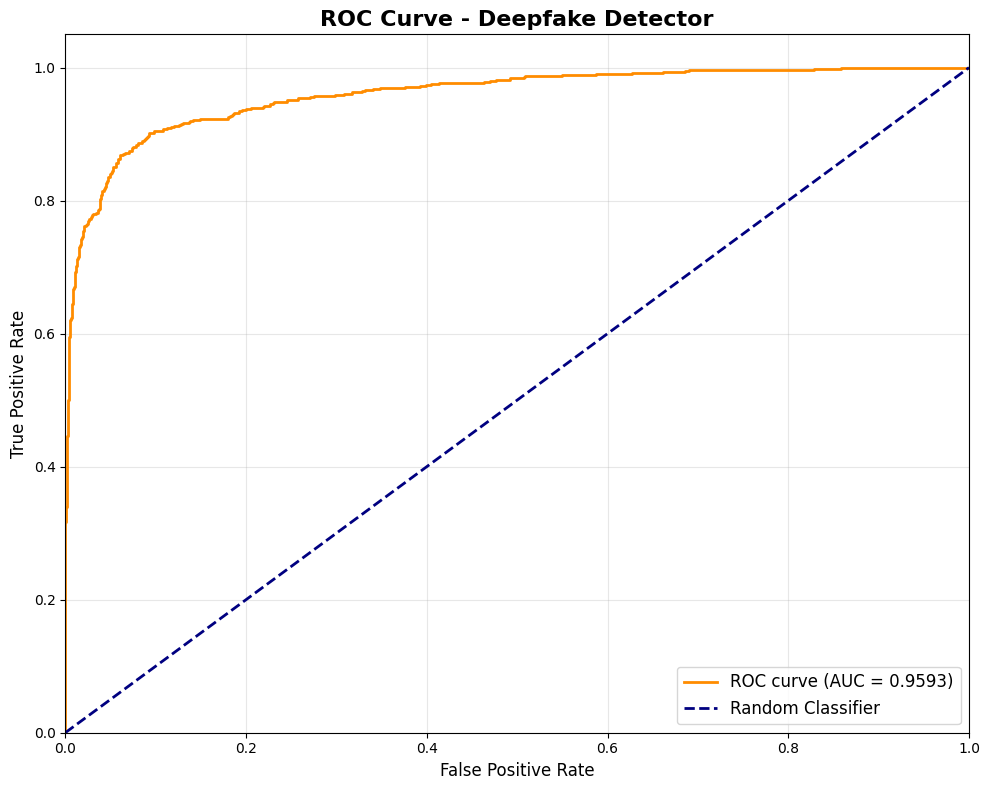


📊 AUC Score: 0.9593
   AUC = 1.0: Perfect classifier
   AUC = 0.5: Random classifier
   AUC = 0.9593: Excellent performance


In [9]:
# 3. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Deepfake Detector', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 AUC Score: {roc_auc:.4f}")
print("   AUC = 1.0: Perfect classifier")
print("   AUC = 0.5: Random classifier")
print(f"   AUC = {roc_auc:.4f}: {'Excellent' if roc_auc > 0.9 else 'Good' if roc_auc > 0.8 else 'Fair'} performance")

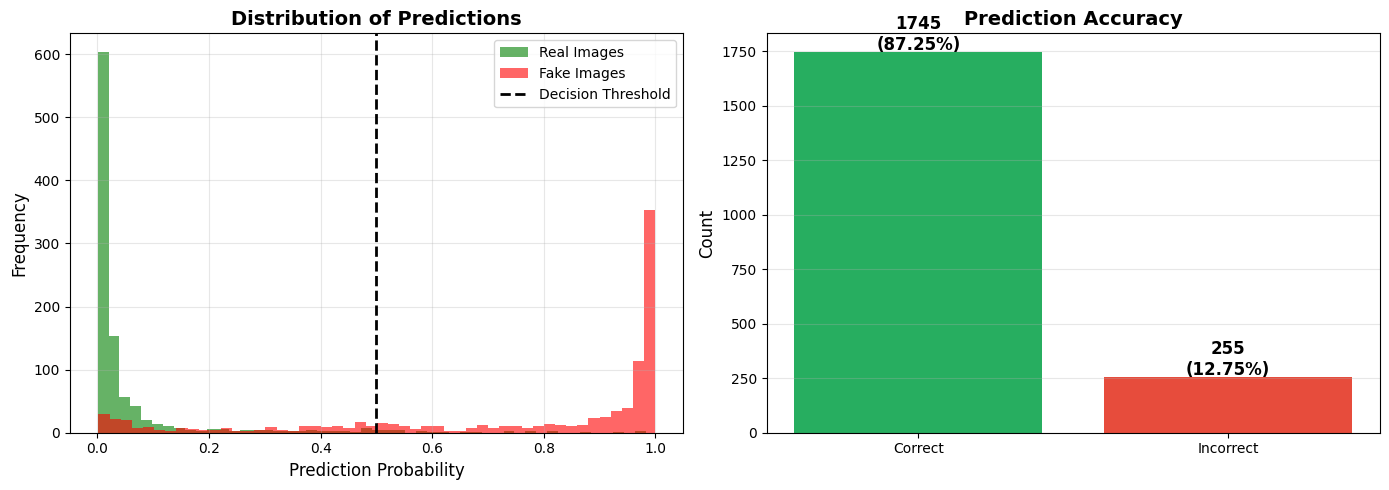

In [15]:
# 4. Prediction Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Separate predictions by true class
real_indices = np.where(y_true == 0)[0]
fake_indices = np.where(y_true == 1)[0]

real_probs_dist = y_pred_probs[real_indices]
fake_probs_dist = y_pred_probs[fake_indices]

# Histogram of prediction probabilities
ax1.hist(real_probs_dist, bins=50, alpha=0.6, label='Real Images', color='green')
ax1.hist(fake_probs_dist, bins=50, alpha=0.6, label='Fake Images', color='red')
ax1.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
ax1.set_xlabel('Prediction Probability', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Predictions', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Bar chart of correct vs incorrect predictions
correct = np.sum(y_true == y_pred)
incorrect = len(y_true) - correct
ax2.bar(['Correct', 'Incorrect'], [correct, incorrect], color=['#27ae60', '#e74c3c'])
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Prediction Accuracy', fontsize=14, fontweight='bold')
ax2.text(0, correct + 10, f'{correct}\n({correct/len(y_true)*100:.2f}%)', 
         ha='center', fontweight='bold', fontsize=12)
ax2.text(1, incorrect + 10, f'{incorrect}\n({incorrect/len(y_true)*100:.2f}%)', 
         ha='center', fontweight='bold', fontsize=12)
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

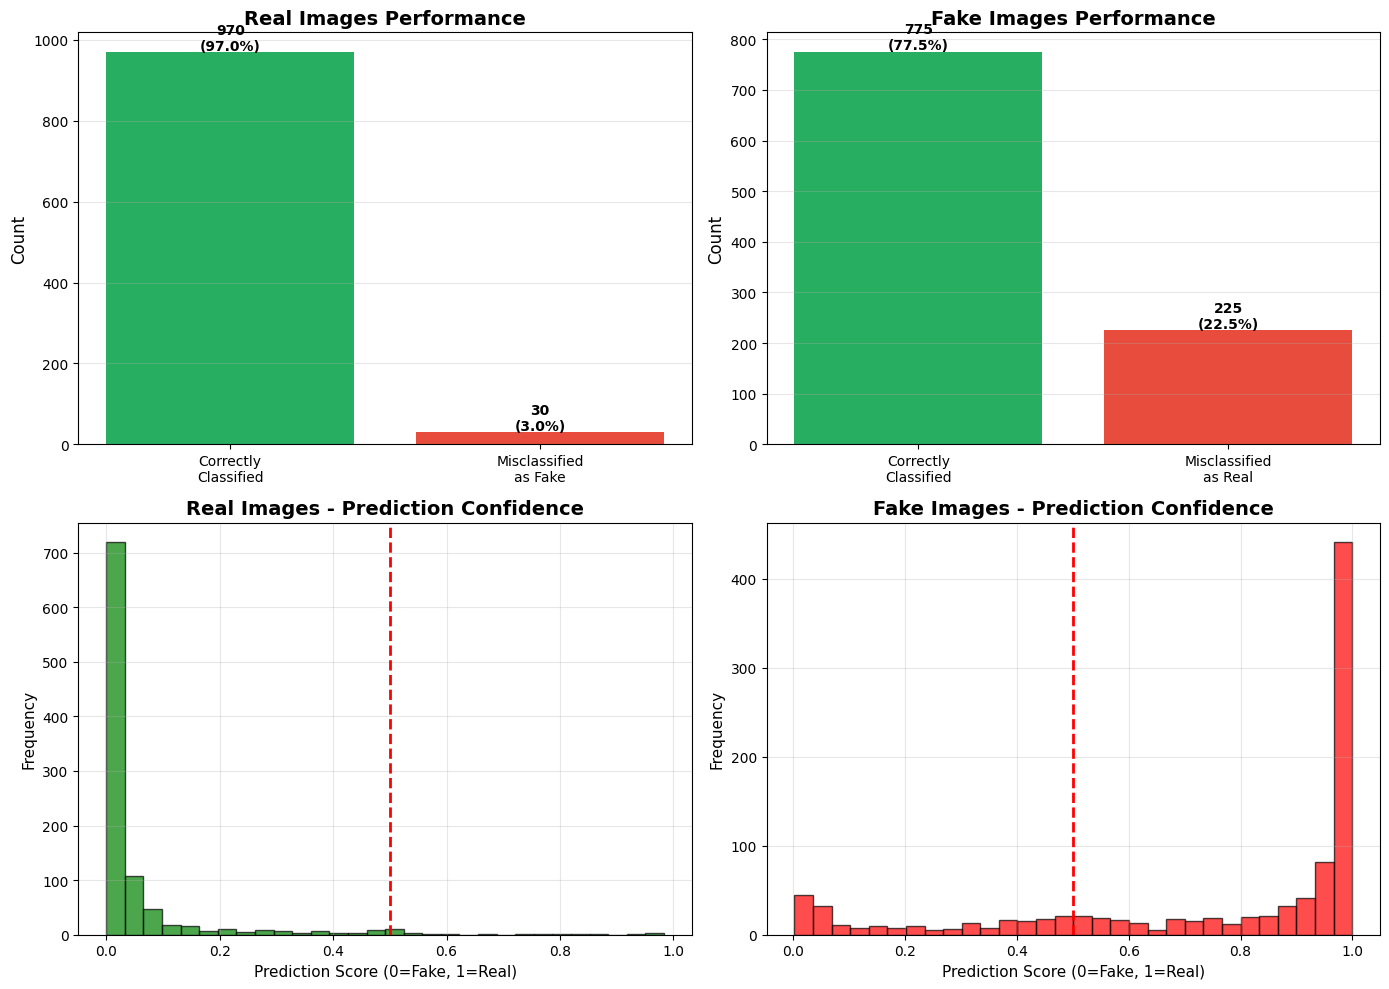

In [16]:
# 5. Per-Class Performance Analysis
fig = plt.figure(figsize=(14, 10))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)

# Real images - correct vs incorrect
real_correct = np.sum((y_true == 0) & (y_pred == 0))
real_incorrect = np.sum((y_true == 0) & (y_pred == 1))
ax1.bar(['Correctly\nClassified', 'Misclassified\nas Fake'], 
        [real_correct, real_incorrect], color=['#27ae60', '#e74c3c'])
ax1.set_title('Real Images Performance', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12)
ax1.text(0, real_correct + 5, f'{real_correct}\n({real_correct/(real_correct+real_incorrect)*100:.1f}%)', 
         ha='center', fontweight='bold')
ax1.text(1, real_incorrect + 5, f'{real_incorrect}\n({real_incorrect/(real_correct+real_incorrect)*100:.1f}%)', 
         ha='center', fontweight='bold')
ax1.grid(alpha=0.3, axis='y')

# Fake images - correct vs incorrect
fake_correct = np.sum((y_true == 1) & (y_pred == 1))
fake_incorrect = np.sum((y_true == 1) & (y_pred == 0))
ax2.bar(['Correctly\nClassified', 'Misclassified\nas Real'], 
        [fake_correct, fake_incorrect], color=['#27ae60', '#e74c3c'])
ax2.set_title('Fake Images Performance', fontsize=14, fontweight='bold')
ax2.set_ylabel('Count', fontsize=12)
ax2.text(0, fake_correct + 5, f'{fake_correct}\n({fake_correct/(fake_correct+fake_incorrect)*100:.1f}%)', 
         ha='center', fontweight='bold')
ax2.text(1, fake_incorrect + 5, f'{fake_incorrect}\n({fake_incorrect/(fake_correct+fake_incorrect)*100:.1f}%)', 
         ha='center', fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

# Confidence distribution for real images
real_indices_conf = np.where(y_true == 0)[0]
real_probs_conf = y_pred_probs[real_indices_conf]
ax3.hist(real_probs_conf, bins=30, color='green', alpha=0.7, edgecolor='black')
ax3.axvline(x=0.5, color='red', linestyle='--', linewidth=2)
ax3.set_title('Real Images - Prediction Confidence', fontsize=14, fontweight='bold')
ax3.set_xlabel('Prediction Score (0=Fake, 1=Real)', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.grid(alpha=0.3)

# Confidence distribution for fake images
fake_indices_conf = np.where(y_true == 1)[0]
fake_probs_conf = y_pred_probs[fake_indices_conf]
ax4.hist(fake_probs_conf, bins=30, color='red', alpha=0.7, edgecolor='black')
ax4.axvline(x=0.5, color='red', linestyle='--', linewidth=2)
ax4.set_title('Fake Images - Prediction Confidence', fontsize=14, fontweight='bold')
ax4.set_xlabel('Prediction Score (0=Fake, 1=Real)', fontsize=11)
ax4.set_ylabel('Frequency', fontsize=11)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# 6. Final Summary Report
print("\n" + "="*70)
print("                   FINAL MODEL EVALUATION SUMMARY")
print("="*70)

print(f"\n📊 DATASET STATISTICS:")
print(f"   Total Test Samples: {len(y_true)}")
print(f"   Real Images: {np.sum(y_true == 0)} ({np.sum(y_true == 0)/len(y_true)*100:.1f}%)")
print(f"   Fake Images: {np.sum(y_true == 1)} ({np.sum(y_true == 1)/len(y_true)*100:.1f}%)")

print(f"\n✅ OVERALL PERFORMANCE:")
print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   AUC:       {roc_auc:.4f}")

print(f"\n🎯 REAL IMAGES (Class 0):")
real_acc = real_correct / (real_correct + real_incorrect)
print(f"   Correctly Identified: {real_correct}/{real_correct + real_incorrect} ({real_acc*100:.2f}%)")
print(f"   False Positive Rate:  {real_incorrect}/{real_correct + real_incorrect} ({(1-real_acc)*100:.2f}%)")

print(f"\n🚨 FAKE IMAGES (Class 1):")
fake_acc = fake_correct / (fake_correct + fake_incorrect)
print(f"   Correctly Identified: {fake_correct}/{fake_correct + fake_incorrect} ({fake_acc*100:.2f}%)")
print(f"   False Negative Rate:  {fake_incorrect}/{fake_correct + fake_incorrect} ({(1-fake_acc)*100:.2f}%)")

print(f"\n💡 MODEL INSIGHTS:")
if accuracy >= 0.9:
    print("   ✅ Excellent performance - Model is highly reliable")
elif accuracy >= 0.8:
    print("   ✅ Good performance - Model is reliable for most cases")
else:
    print("   ⚠️  Fair performance - Model needs improvement")

if abs(real_acc - fake_acc) < 0.05:
    print("   ✅ Balanced performance across both classes")
else:
    print(f"   ⚠️  Imbalanced - Better at detecting {'Real' if real_acc > fake_acc else 'Fake'} images")

print("\n" + "="*70)
print("                         EVALUATION COMPLETE")
print("="*70)


                   FINAL MODEL EVALUATION SUMMARY

📊 DATASET STATISTICS:
   Total Test Samples: 2000
   Real Images: 1000 (50.0%)
   Fake Images: 1000 (50.0%)

✅ OVERALL PERFORMANCE:
   Accuracy:  0.8725 (87.25%)
   Precision: 0.9627
   Recall:    0.7750
   F1-Score:  0.8587
   AUC:       0.9593

🎯 REAL IMAGES (Class 0):
   Correctly Identified: 970/1000 (97.00%)
   False Positive Rate:  30/1000 (3.00%)

🚨 FAKE IMAGES (Class 1):
   Correctly Identified: 775/1000 (77.50%)
   False Negative Rate:  225/1000 (22.50%)

💡 MODEL INSIGHTS:
   ✅ Good performance - Model is reliable for most cases
   ⚠️  Imbalanced - Better at detecting Real images

                         EVALUATION COMPLETE


Total False Negatives: 225
Average confidence (should be <0.5): 0.2232
Min confidence: 0.0017
Max confidence: 0.4986

These fake images have scores >=0.5, making model think they're real
This suggests the model needs better feature extraction for fake detection


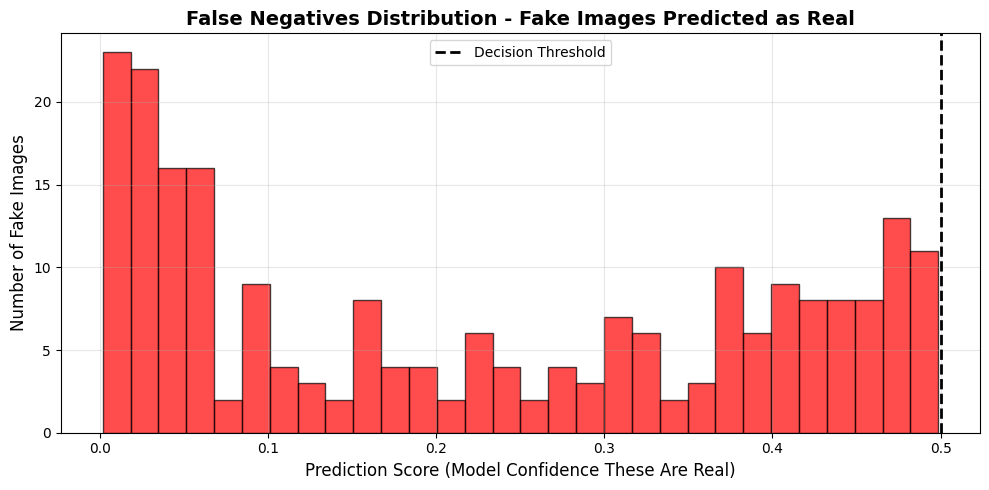

In [18]:
# Find false negatives (fake images predicted as real)
false_negative_indices = np.where((y_true == 1) & (y_pred == 0))[0]
false_negative_probs = y_pred_probs[false_negative_indices]

print(f"Total False Negatives: {len(false_negative_indices)}")
print(f"Average confidence (should be <0.5): {np.mean(false_negative_probs):.4f}")
print(f"Min confidence: {np.min(false_negative_probs):.4f}")
print(f"Max confidence: {np.max(false_negative_probs):.4f}")
print(f"\nThese fake images have scores >=0.5, making model think they're real")
print("This suggests the model needs better feature extraction for fake detection")

# Show distribution of false negative confidences
plt.figure(figsize=(10, 5))
plt.hist(false_negative_probs, bins=30, color='red', alpha=0.7, edgecolor='black')
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
plt.xlabel('Prediction Score (Model Confidence These Are Real)', fontsize=12)
plt.ylabel('Number of Fake Images', fontsize=12)
plt.title('False Negatives Distribution - Fake Images Predicted as Real', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze False Negatives
Identify which fake images are being misclassified as real to understand model weaknesses.